In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sportsimages/Capture.JPG
/kaggle/input/sportsimages/badm.JPG
/kaggle/input/sports-image-classification/dataset/sample_submission.csv
/kaggle/input/sports-image-classification/dataset/train.csv
/kaggle/input/sports-image-classification/dataset/test.csv
/kaggle/input/sports-image-classification/dataset/test/730a467265.jpg
/kaggle/input/sports-image-classification/dataset/test/12a9b208fe.jpg
/kaggle/input/sports-image-classification/dataset/test/5e2050af87.jpg
/kaggle/input/sports-image-classification/dataset/test/1deb80beb0.jpg
/kaggle/input/sports-image-classification/dataset/test/72d05ce1b9.jpg
/kaggle/input/sports-image-classification/dataset/test/976e8009cd.jpg
/kaggle/input/sports-image-classification/dataset/test/04b282ddb5.jpg
/kaggle/input/sports-image-classification/dataset/test/b07060a4b2.jpg
/kaggle/input/sports-image-classification/dataset/test/63452153e7.jpg
/kaggle/input/sports-image-classification/dataset/test/90fe17fb0a.jpg
/kaggle/input/sports-image-classif

In [2]:
train_df = pd.read_csv('/kaggle/input/sports-image-classification/dataset/train.csv')
print(train_df.head())


         image_ID      label
0  7c225f7b61.jpg  Badminton
1         b31.jpg  Badminton
2  acb146546c.jpg  Badminton
3  0e62f4d8f2.jpg  Badminton
4  cfd2c28c74.jpg    Cricket


In [3]:
test_df = pd.read_csv('/kaggle/input/sports-image-classification/dataset/test.csv')
print(test_df.head())


         image_ID
0  f5e13966e7.jpg
1  6674191b4e.jpg
2  91b5f8b7a9.jpg
3  393119b6d6.jpg
4  1ce5f81578.jpg


In [4]:
import cv2
import os
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

2025-05-10 20:01:45.988922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746907306.471209      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746907306.602798      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
def process_data(data, folder, target_size=(128, 128)):
    images = []
    labels = []
    
    for index, row in data.iterrows():
        filename = row['image_ID']  
        class_name = row['label']   
        
        image_path = os.path.join(folder, filename)
        
        image = cv2.imread(image_path)
        if image is None:
            continue 
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, target_size)
        image = image.astype('float32') / 255.0
        image = image[..., np.newaxis]

        images.append(image)
        labels.append(class_name)
    
    return np.array(images), np.array(labels)




In [6]:
data = pd.read_csv("/kaggle/input/sports-image-classification/dataset/train.csv")
folder = "/kaggle/input/sports-image-classification/dataset/train"

In [7]:
images, labels = process_data(data, folder)
print("Dataset shape:", images.shape, labels.shape)

Dataset shape: (8227, 128, 128, 1) (8227,)


In [8]:
print("Min pixel value:", np.min(images))
print("Max pixel value:", np.max(images))

Min pixel value: 0.0
Max pixel value: 1.0


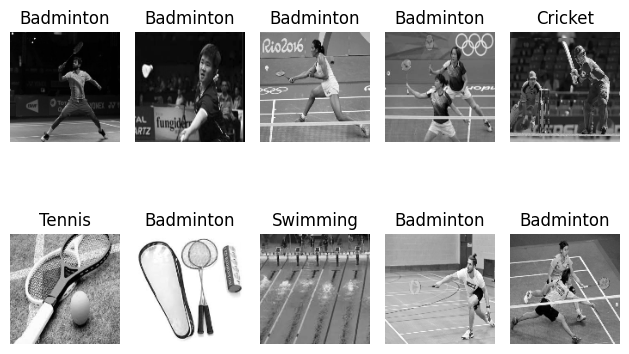

In [9]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"{labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Class distribution:
Badminton: 1394
Cricket: 1556
Tennis: 1445
Swimming: 595
Soccer: 1188
Wrestling: 1471
Karate: 578


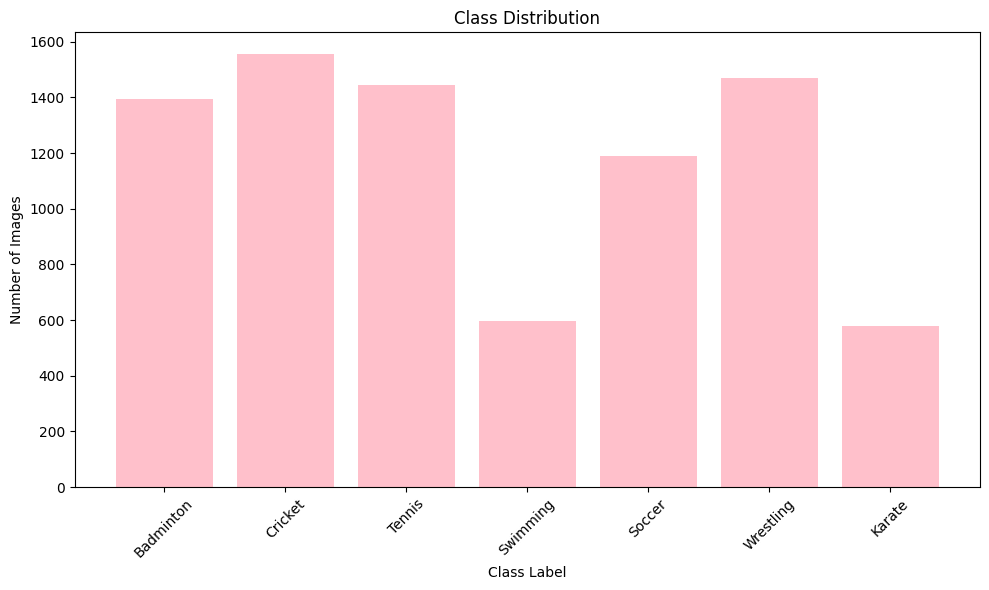

In [10]:
class_counts = Counter(labels)
print("Class distribution:")
for label, count in class_counts.items():
    print(f"{label}: {count}")


classes = list(class_counts.keys())
counts = list(class_counts.values())


plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='pink')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

target_classes = ['Swimming', 'Karate']
class_filter = np.isin(labels, target_classes)
target_images = images[class_filter]
target_labels = labels[class_filter]

augment_no=600
augmented_images = []
augmented_labels = []
num_originals = len(target_images)
n_aug = max(1, augment_no // num_originals) #3ashan y3ml ll sora el wahda augment b3dad mo3yn

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
) #random changes ll sowar

for i in range(num_originals):
    img = target_images[i] 
    label = target_labels[i]
    
    img = np.expand_dims(img, axis=0)  #shape baa kda(1, 128, 128, 1)

    aug_iter = datagen.flow(img, batch_size=1)
    for _ in range(n_aug):
        aug_img = next(aug_iter)[0]  
        augmented_images.append(aug_img.astype('float32'))
        augmented_labels.append(label)

augmented_images = np.stack(augmented_images, axis=0).astype('float32')
augmented_labels = np.array(augmented_labels, dtype=str)

images = np.concatenate([images, augmented_images], axis=0)
labels = np.concatenate([labels, augmented_labels], axis=0)

print("After augmentation:", images.shape, labels.shape)


After augmentation: (9400, 128, 128, 1) (9400,)


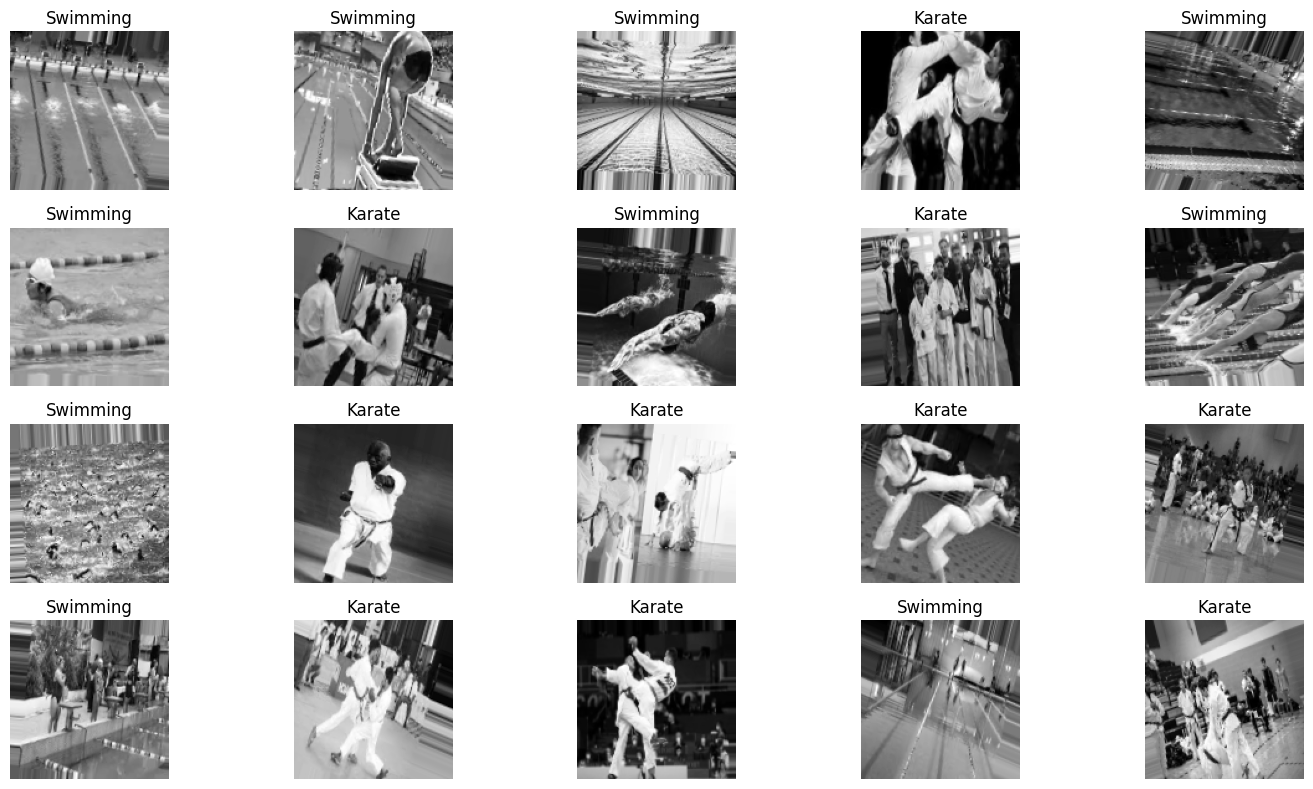

In [12]:
num_to_plot = 20
plt.figure(figsize=(15, 8))

for i in range(num_to_plot):
    plt.subplot(4, 5, i + 1)
    plt.imshow(augmented_images[i].squeeze(), cmap='gray')
    plt.title(augmented_labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

Class distribution:
Badminton: 1394
Cricket: 1556
Tennis: 1445
Swimming: 1190
Soccer: 1188
Wrestling: 1471
Karate: 1156


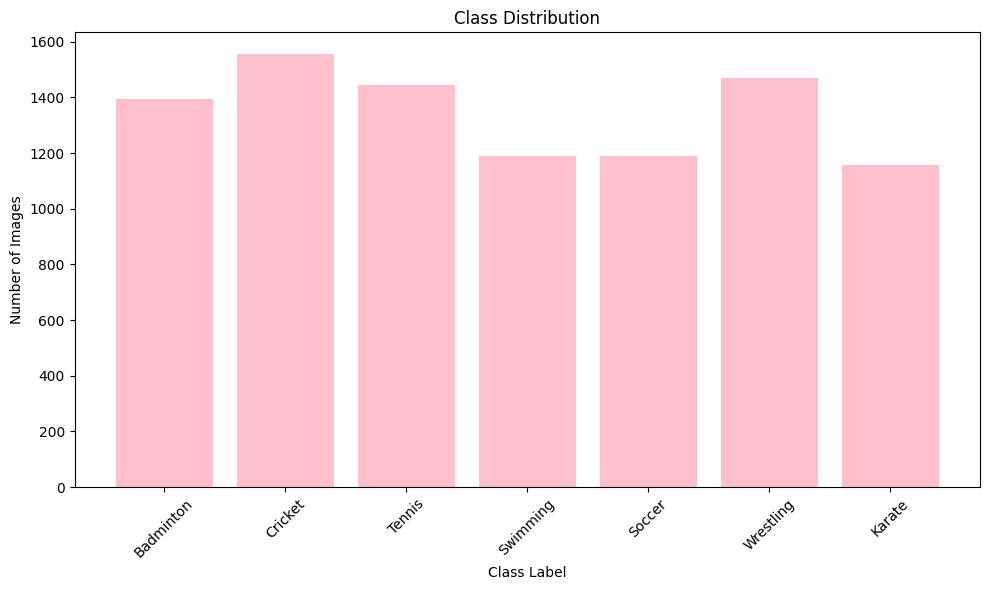

In [13]:
class_counts = Counter(labels)
print("Class distribution:")
for label, count in class_counts.items():
    print(f"{label}: {count}")


classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='pink')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 # **Data Splitting**

In [14]:
x_train, x_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print("Train shape:", x_train.shape)
print("Validation shape:", x_val.shape)
print("Test shape:", x_test.shape)

Train shape: (7520, 128, 128, 1)
Validation shape: (940, 128, 128, 1)
Test shape: (940, 128, 128, 1)


 # **Label Encoder**

In [15]:
encoder = LabelEncoder()

y_train_enc = encoder.fit_transform(y_train)
y_val_enc = encoder.transform(y_val)
y_test_enc = encoder.transform(y_test)

 # **One-hot Encoding**

In [16]:
y_train_ohe = to_categorical(y_train_enc)
y_val_ohe = to_categorical(y_val_enc)
y_test_ohe = to_categorical(y_test_enc)

In [17]:
print("Sample One-Hot Encoded Labels (Training):")
print(y_train_ohe[:5]) 

print("Sample One-Hot Encoded Labels (Validation):")
print(y_val_ohe[:5]) 

print("Sample One-Hot Encoded Labels (Test):")
print(y_test_ohe[:5])


Sample One-Hot Encoded Labels (Training):
[[0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]
Sample One-Hot Encoded Labels (Validation):
[[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]
Sample One-Hot Encoded Labels (Test):
[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


In [18]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# train_datagen = ImageDataGenerator(
#     rotation_range=20,
#     height_shift_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
# )
# valid_datagen = ImageDataGenerator()
# train_generator = train_datagen.flow(x_train, y_train_ohe, batch_size=32)
# valid_generator = valid_datagen.flow(x_val, y_val_ohe, batch_size=32)

 # **Model Architecture**

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Input(shape=(128, 128, 1)))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.002)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.002)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.002)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.002)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [42]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,5

 Total params: 305,639 (1.17 MB)

 Trainable params: 304,743 (1.16 MB)

 Non-trainable params: 896 (3.50 KB)

 # **Model Compilation**

In [43]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

 # **Callbacks**

In [44]:
tensorboard_callback= tf.keras.callbacks.TensorBoard('logs')

In [45]:
from tensorflow.keras.callbacks import EarlyStopping
Ecallback = EarlyStopping(monitor='loss',patience=3)

In [46]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

 # **Train**

In [47]:
hist=model.fit(x=x_train, y=y_train_ohe, batch_size=16, epochs=50,validation_data=(x_val, y_val_ohe), callbacks=[tensorboard_callback, Ecallback, reduce_lr], shuffle=True)
#hist=model.fit(train_generator, epochs=350,validation_data=valid_generator, callbacks=[tensorboard_callback, callbacks1])

Epoch 1/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.2569 - loss: 2.6547 - val_accuracy: 0.2223 - val_loss: 2.3628 - learning_rate: 0.0010
Epoch 2/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.4112 - loss: 1.9318 - val_accuracy: 0.4362 - val_loss: 1.7219 - learning_rate: 0.0010
Epoch 3/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.4715 - loss: 1.6543 - val_accuracy: 0.3447 - val_loss: 3.3387 - learning_rate: 0.0010
Epoch 4/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.5282 - loss: 1.5042 - val_accuracy: 0.2894 - val_loss: 2.7438 - learning_rate: 0.0010
Epoch 5/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.5320 - loss: 1.4818 - val_accuracy: 0.5340 - val_loss: 1.5054 - learning_rate: 0.0010
Epoch 6/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.5704 - loss: 1.3820 - val_accuracy: 0.5553 - val_loss: 1.4137 - learning_rate: 0.0010
Epoch 7/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.5699 - l

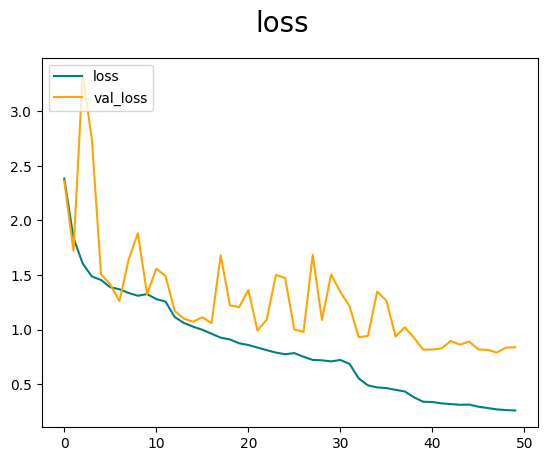

In [48]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

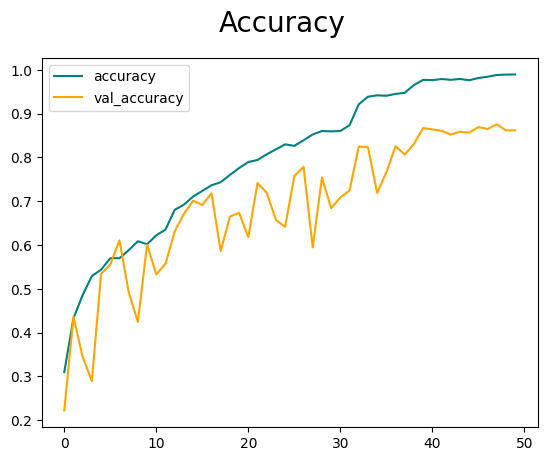

In [49]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [50]:
test_loss, test_accuracy = model.evaluate(x_test, y_test_ohe)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8546 - loss: 0.9259
Test Loss: 0.8816441893577576
Test Accuracy: 0.8542553186416626


In [51]:
def process_test_data(data, folder, target_size=(128, 128)):
    images = []
    
    for index, row in data.iterrows():
        filename = row['image_ID']     
        
        image_path = os.path.join(folder, filename)
        
        image = cv2.imread(image_path)
        if image is None:
            continue 
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, target_size)
        # Scale the image to [0, 1] by dividing by 255.0
        image = image.astype('float32') / 255.0
        image = image[..., np.newaxis]  # Add channel dimension

        images.append(image)
    
    return np.array(images)

In [52]:
csv_path = '/kaggle/input/sports-image-classification/dataset/test.csv'
image_folder = '/kaggle/input/sports-image-classification/dataset/test'
test_df = pd.read_csv(csv_path)
test_images = process_test_data(test_df, image_folder)

In [53]:
print (test_images.shape)

(2056, 128, 128, 1)


In [54]:
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


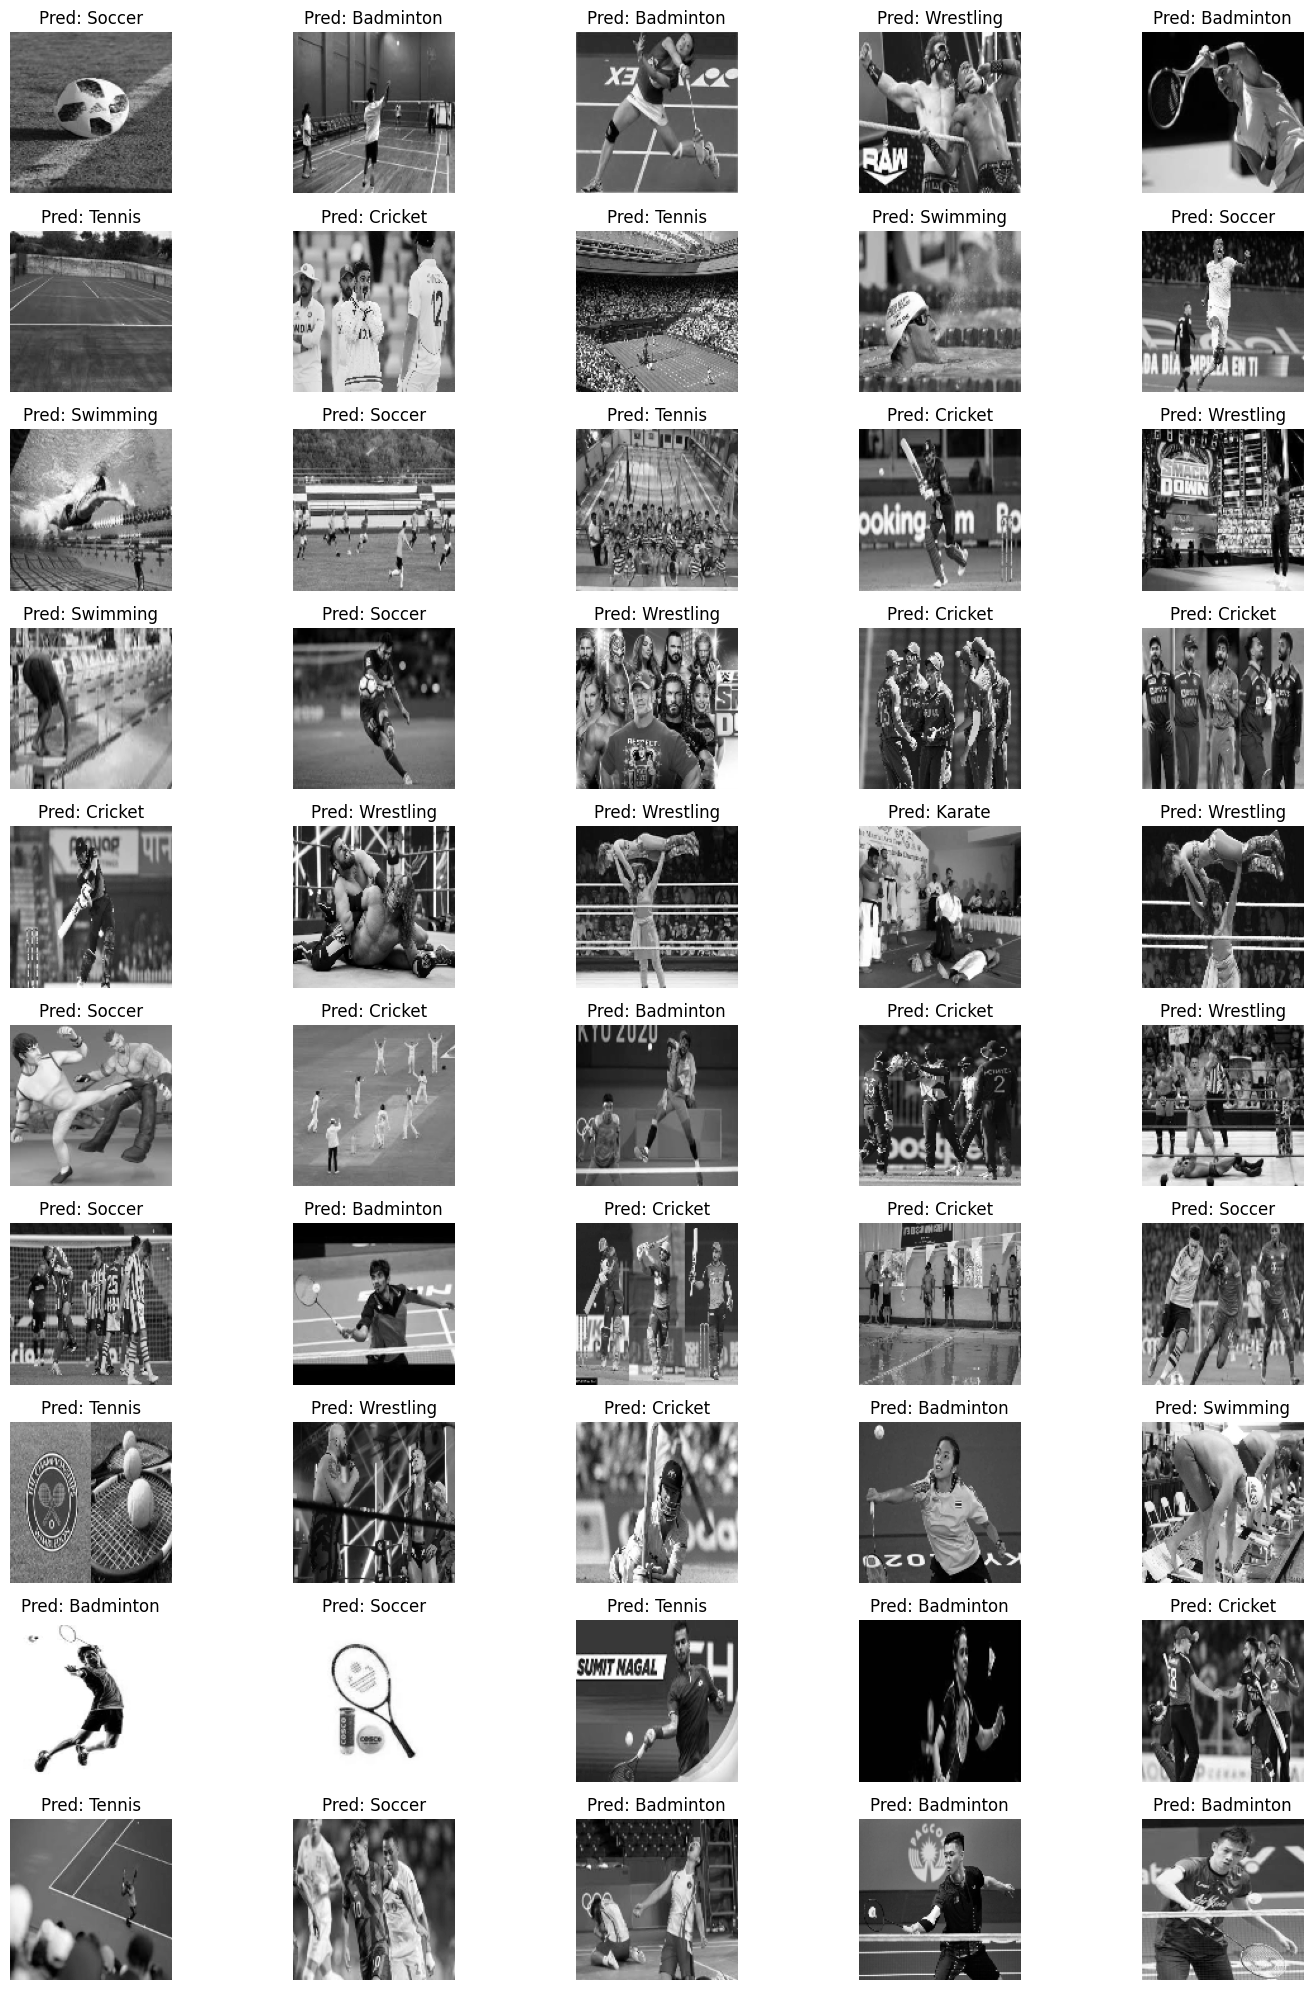

In [55]:
class_names = list(encoder.classes_)

num_images = 50
rows = 10
cols = 5
plt.figure(figsize=(15, 20))


for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    plt.title(f"Pred: {class_names[predicted_classes[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [59]:
model.save('sports_classifier.h5')